In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import itertools

%matplotlib inline

In [ ]:
loc = "/content/"

raw_data_1 = pd.read_csv(loc + '2016-2017.csv')
raw_data_2 = pd.read_csv(loc + '2017-2018.csv')
raw_data_3 = pd.read_csv(loc + '2018-2019.csv')
raw_data_4 = pd.read_csv(loc + '2019-2020.csv')


In [ ]:
# Parse data as time

def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%d/%m/%y').date()


def parse_date_other(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%d/%m/%Y').date()

raw_data_1.Date = raw_data_1.Date.apply(parse_date)
raw_data_2.Date = raw_data_2.Date.apply(parse_date_other)
raw_data_3.Date = raw_data_3.Date.apply(parse_date_other)

In [ ]:
columns_req = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR']

playing_statistics_1 = raw_data_1[columns_req]
playing_statistics_2 = raw_data_2[columns_req]
playing_statistics_3 = raw_data_3[columns_req]
playing_statistics_4 = raw_data_4[columns_req]
# playing_statistics_5 = raw_data_5[columns_req]

In [ ]:

def get_goals_scored(playing_stat):

    teams = {}

    for i in playing_stat.groupby('HomeTeam').mean(numeric_only=True).T.columns:  #<- Changed this line to only include numeric columns
        teams[i] = []

    # the value corresponding to keys is a list containing the match location.
    for i in range(len(playing_stat)):
        HTGS = playing_stat.iloc[i]['FTHG']
        ATGS = playing_stat.iloc[i]['FTAG']
        teams[playing_stat.iloc[i].HomeTeam].append(HTGS)
        teams[playing_stat.iloc[i].AwayTeam].append(ATGS)

    # Create a dataframe for goals scored where rows are teams and cols are matchweek.
    GoalsScored = pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T
    GoalsScored[0] = 0
    # Aggregate to get uptil that point
    for i in range(2,39):
        GoalsScored[i] = GoalsScored[i] + GoalsScored[i-1]
    return GoalsScored

# Gets the goals conceded agg arranged by teams and matchweek
def get_goals_conceded(playing_stat):
    # Create a dictionary with team names as keys
    teams = {}

    for i in playing_stat.groupby('HomeTeam').mean(numeric_only=True).T.columns:
        teams[i] = []

    # the value corresponding to keys is a list containing the match location.
    for i in range(len(playing_stat)):
        ATGC = playing_stat.iloc[i]['FTHG']
        HTGC = playing_stat.iloc[i]['FTAG']
        teams[playing_stat.iloc[i].HomeTeam].append(HTGC)
        teams[playing_stat.iloc[i].AwayTeam].append(ATGC)

    # Create a dataframe for goals scored where rows are teams and cols are matchweek.
    GoalsConceded = pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T
    GoalsConceded[0] = 0
    # Aggregate to get uptil that point
    for i in range(2,39):
        GoalsConceded[i] = GoalsConceded[i] + GoalsConceded[i-1]
    return GoalsConceded

def get_gss(playing_stat):
    GC = get_goals_conceded(playing_stat)
    GS = get_goals_scored(playing_stat)

    j = 0
    HTGS = []
    ATGS = []
    HTGC = []
    ATGC = []

    for i in range(380):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HTGS.append(GS.loc[ht][j])
        ATGS.append(GS.loc[at][j])
        HTGC.append(GC.loc[ht][j])
        ATGC.append(GC.loc[at][j])

        if ((i + 1)% 10) == 0:
            j = j + 1

    playing_stat['HTGS'] = HTGS
    playing_stat['ATGS'] = ATGS
    playing_stat['HTGC'] = HTGC
    playing_stat['ATGC'] = ATGC

    return playing_stat
playing_statistics_1 = get_gss(playing_statistics_1)
playing_statistics_2 = get_gss(playing_statistics_2)
playing_statistics_3 = get_gss(playing_statistics_3)
playing_statistics_4 = get_gss(playing_statistics_4)
# playing_statistics_5 = get_gss(playing_statistics_5)





<ipython-input-5-58f2009e27af>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playing_stat['HTGS'] = HTGS
<ipython-input-5-58f2009e27af>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playing_stat['ATGS'] = ATGS
<ipython-input-5-58f2009e27af>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [ ]:
def get_points(result):
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    else:
        return 0


def get_cuml_points(matchres):
    matchres_points = matchres.applymap(get_points)
    for i in range(2,39):
        matchres_points[i] = matchres_points[i] + matchres_points[i-1]

    matchres_points.insert(column =0, loc = 0, value = [0*i for i in range(20)])
    return matchres_points

def get_matchres(playing_stat):
    # Create a dictionary with team names as keys
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean(numeric_only=True).T.columns:
        teams[i] = []

    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        if playing_stat.iloc[i].FTR == 'H':
            teams[playing_stat.iloc[i].HomeTeam].append('W')
            teams[playing_stat.iloc[i].AwayTeam].append('L')
        elif playing_stat.iloc[i].FTR == 'A':
            teams[playing_stat.iloc[i].AwayTeam].append('W')
            teams[playing_stat.iloc[i].HomeTeam].append('L')
        else:
            teams[playing_stat.iloc[i].AwayTeam].append('D')
            teams[playing_stat.iloc[i].HomeTeam].append('D')

    return pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T

def get_agg_points(playing_stat):
    matchres = get_matchres(playing_stat)
    cum_pts = get_cuml_points(matchres)
    HTP = []
    ATP = []
    j = 0
    for i in range(380):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HTP.append(cum_pts.loc[ht][j])
        ATP.append(cum_pts.loc[at][j])

        if ((i + 1)% 10) == 0:
            j = j + 1

    playing_stat['HTP'] = HTP
    playing_stat['ATP'] = ATP
    return playing_stat

# Apply to each dataset
playing_statistics_1 = get_agg_points(playing_statistics_1)
playing_statistics_2 = get_agg_points(playing_statistics_2)
playing_statistics_3 = get_agg_points(playing_statistics_3)
playing_statistics_4 = get_agg_points(playing_statistics_4)




<ipython-input-6-296a90d284c2>:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  matchres_points = matchres.applymap(get_points)
<ipython-input-6-296a90d284c2>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playing_stat['HTP'] = HTP
<ipython-input-6-296a90d284c2>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playing_stat['ATP'] = ATP
<ipython-input-6-296a90d284c2>:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  matchres_poi

In [ ]:
def get_form(playing_stat,num):
    form = get_matchres(playing_stat)
    form_final = form.copy()
    for i in range(num,39):
        form_final[i] = ''
        j = 0
        while j < num:
            form_final[i] += form[i-j]
            j += 1
    return form_final

def add_form(playing_stat,num):
    form = get_form(playing_stat,num)
    h = ['M' for i in range(num * 10)]
    a = ['M' for i in range(num * 10)]

    j = num
    for i in range((num*10),380):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam

        past = form.loc[ht][j]
        h.append(past[num-1])

        past = form.loc[at][j]
        a.append(past[num-1])

        if ((i + 1)% 10) == 0:
            j = j + 1

    playing_stat['HM' + str(num)] = h
    playing_stat['AM' + str(num)] = a


    return playing_stat

def add_form_df(playing_statistics):
    playing_statistics = add_form(playing_statistics,1)
    playing_statistics = add_form(playing_statistics,2)
    playing_statistics = add_form(playing_statistics,3)
    playing_statistics = add_form(playing_statistics,4)
    playing_statistics = add_form(playing_statistics,5)
    return playing_statistics

# Make changes to df
playing_statistics_1 = add_form_df(playing_statistics_1)
playing_statistics_2 = add_form_df(playing_statistics_2)
playing_statistics_3 = add_form_df(playing_statistics_3)
playing_statistics_4 = add_form_df(playing_statistics_4)



<ipython-input-7-14c66cb911f9>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playing_stat['HM' + str(num)] = h
<ipython-input-7-14c66cb911f9>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playing_stat['AM' + str(num)] = a
<ipython-input-7-14c66cb911f9>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [ ]:
cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3',
        'HM4', 'HM5', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5' ]

playing_statistics_1 = playing_statistics_1[cols]
playing_statistics_2 = playing_statistics_2[cols]
playing_statistics_3 = playing_statistics_3[cols]
playing_statistics_4 = playing_statistics_4[cols]

In [ ]:
import pandas as pd

# List of DataFrames for different seasons
dfs = [playing_statistics_1, playing_statistics_2, playing_statistics_3, playing_statistics_4]

# Function to calculate league positions
def calculate_league_positions(matches):
    # Get unique teams
    teams = pd.concat([matches['HomeTeam'], matches['AwayTeam']]).unique()
    standings = pd.DataFrame({'Team': teams, 'Points': 0, 'GD': 0, 'GoalsScored': 0})

    # Iterate through matches and update standings
    for _, row in matches.iterrows():
        home_team, away_team = row['HomeTeam'], row['AwayTeam']
        home_goals, away_goals = row['FTHG'], row['FTAG']

        # Find team positions in standings
        home_idx = standings.index[standings['Team'] == home_team][0]
        away_idx = standings.index[standings['Team'] == away_team][0]

        # Update points and goal differences
        if home_goals > away_goals:  # Home win
            standings.at[home_idx, 'Points'] += 3
        elif home_goals < away_goals:  # Away win
            standings.at[away_idx, 'Points'] += 3
        else:  # Draw
            standings.at[home_idx, 'Points'] += 1
            standings.at[away_idx, 'Points'] += 1

        # Update goal difference and total goals scored
        standings.at[home_idx, 'GD'] += (home_goals - away_goals)
        standings.at[away_idx, 'GD'] += (away_goals - home_goals)
        standings.at[home_idx, 'GoalsScored'] += home_goals
        standings.at[away_idx, 'GoalsScored'] += away_goals

    # Rank teams based on Points, GD, and GoalsScored
    standings.sort_values(by=['Points', 'GD', 'GoalsScored'], ascending=[False, False, False], inplace=True)
    standings['Position'] = range(1, len(standings) + 1)  # Assign ranks

    return standings[['Team', 'Position']]

# Process each DataFrame
for i in range(len(dfs)):
    df = dfs[i]

    # Calculate league positions
    league_positions = calculate_league_positions(df)

    # Merge positions back to the dataset
    df = df.merge(league_positions, left_on="HomeTeam", right_on="Team", how="left").rename(columns={'Position': 'HomeTeamLP'})
    df = df.merge(league_positions, left_on="AwayTeam", right_on="Team", how="left").rename(columns={'Position': 'AwayTeamLP'})

    # Drop unnecessary 'Team' columns
    df.drop(columns=['Team_x', 'Team_y'], inplace=True)

    # Update the original DataFrame in the list
    dfs[i] = df

# Assign back to original variables
playing_statistics_1, playing_statistics_2, playing_statistics_3, playing_statistics_4 = dfs


In [ ]:
def get_mw(playing_stat):
    j = 1
    MatchWeek = []
    for i in range(380):
        MatchWeek.append(j)
        if ((i + 1)% 10) == 0:
            j = j + 1
    playing_stat['MW'] = MatchWeek
    return playing_stat

playing_statistics_1 = get_mw(playing_statistics_1)
playing_statistics_2 = get_mw(playing_statistics_2)
playing_statistics_3 = get_mw(playing_statistics_3)
playing_statistics_4 = get_mw(playing_statistics_4)

In [ ]:
playing_stat = pd.concat([playing_statistics_1,
                          playing_statistics_2,
                          playing_statistics_3,
                          playing_statistics_4], ignore_index=True)


# Gets the form points.
def get_form_points(string):
    sum = 0
    for letter in string:
        sum += get_points(letter)
    return sum

playing_stat['HTFormPtsStr'] = playing_stat['HM1'] + playing_stat['HM2'] + playing_stat['HM3'] + playing_stat['HM4'] + playing_stat['HM5']
playing_stat['ATFormPtsStr'] = playing_stat['AM1'] + playing_stat['AM2'] + playing_stat['AM3'] + playing_stat['AM4'] + playing_stat['AM5']

playing_stat['HTFormPts'] = playing_stat['HTFormPtsStr'].apply(get_form_points)
playing_stat['ATFormPts'] = playing_stat['ATFormPtsStr'].apply(get_form_points)

# Identify Win/Loss Streaks if any.
def get_3game_ws(string):
    if string[-3:] == 'WWW':
        return 1
    else:
        return 0

def get_5game_ws(string):
    if string == 'WWWWW':
        return 1
    else:
        return 0

def get_3game_ls(string):
    if string[-3:] == 'LLL':
        return 1
    else:
        return 0

def get_5game_ls(string):
    if string == 'LLLLL':
        return 1
    else:
        return 0

playing_stat['HTWinStreak3'] = playing_stat['HTFormPtsStr'].apply(get_3game_ws)
playing_stat['HTWinStreak5'] = playing_stat['HTFormPtsStr'].apply(get_5game_ws)
playing_stat['HTLossStreak3'] = playing_stat['HTFormPtsStr'].apply(get_3game_ls)
playing_stat['HTLossStreak5'] = playing_stat['HTFormPtsStr'].apply(get_5game_ls)

playing_stat['ATWinStreak3'] = playing_stat['ATFormPtsStr'].apply(get_3game_ws)
playing_stat['ATWinStreak5'] = playing_stat['ATFormPtsStr'].apply(get_5game_ws)
playing_stat['ATLossStreak3'] = playing_stat['ATFormPtsStr'].apply(get_3game_ls)
playing_stat['ATLossStreak5'] = playing_stat['ATFormPtsStr'].apply(get_5game_ls)

playing_stat.keys()

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTGS', 'ATGS',
       'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3', 'HM4', 'HM5', 'AM1',
       'AM2', 'AM3', 'AM4', 'AM5', 'HomeTeamLP', 'AwayTeamLP', 'MW',
       'HTFormPtsStr', 'ATFormPtsStr', 'HTFormPts', 'ATFormPts',
       'HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5',
       'ATWinStreak3', 'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5'],
      dtype='object')

In [ ]:

# Get Goal Difference
playing_stat['HTGD'] = playing_stat['HTGS'] - playing_stat['HTGC']
playing_stat['ATGD'] = playing_stat['ATGS'] - playing_stat['ATGC']

# Diff in points
playing_stat['DiffPts'] = playing_stat['HTP'] - playing_stat['ATP']
playing_stat['DiffFormPts'] = playing_stat['HTFormPts'] - playing_stat['ATFormPts']

# Diff in last year positions
playing_stat['DiffLP'] = playing_stat['HomeTeamLP'] - playing_stat['AwayTeamLP']

In [ ]:

# Scale DiffPts , DiffFormPts, HTGD, ATGD by Matchweek.
cols = ['HTGD','ATGD','DiffPts','DiffFormPts','HTP','ATP']
playing_stat.MW = playing_stat.MW.astype(float)

for col in cols:
    playing_stat[col] = playing_stat[col] / playing_stat.MW

In [ ]:
def only_hw(string):
    if string == 'H':
        return 'H'
    else:
        return 'NH'

playing_stat['FTR'] = playing_stat.FTR.apply(only_hw)

# Testing set (2015-16 season)
playing_stat_test = playing_stat[5700:]

In [ ]:

playing_stat.to_csv(loc + "final_dataset_add.csv")
playing_stat_test.to_csv(loc+"test.csv")

In [ ]:
import pandas as pd

# Read the two CSV files into pandas DataFrames
df1 = pd.read_csv('final_dataset.csv')
df2 = pd.read_csv('final_dataset_add.csv')

# Concatenate the two DataFrames
concatenated_df = pd.concat([df1, df2], ignore_index=True)

# Save the concatenated DataFrame to a new CSV file
concatenated_df.to_csv('concatenated_file.csv', index=False)


In [ ]:
data = pd.read_csv('/content/concatenated_file.csv')

# Remove first 3 matchweeks
data = data[data.MW > 3]

data.drop(['Unnamed: 0','HomeTeam', 'AwayTeam', 'Date', 'MW', 'HTFormPtsStr', 'ATFormPtsStr', 'FTHG', 'FTAG',
           'HTGS', 'ATGS', 'HTGC', 'ATGC','HomeTeamLP', 'AwayTeamLP','DiffPts','HTFormPts','ATFormPts',
           'HM4','HM5','AM4','AM5','HTLossStreak5','ATLossStreak5','HTWinStreak5','ATWinStreak5',
           'HTWinStreak3','HTLossStreak3','ATWinStreak3','ATLossStreak3'],axis=1, inplace=True)


# Preview data.
display(data.head())

,FTR,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HTGD,ATGD,DiffFormPts,DiffLP
30,H,1.25,1.00,D,D,W,D,W,L,0.50,0.25,0.25,-16.0
31,NH,0.75,0.25,L,L,W,D,L,L,-0.50,-0.75,0.50,-2.0
32,H,1.00,1.00,L,D,W,D,W,L,0.00,0.25,0.00,-3.0
33,NH,0.75,0.50,L,L,W,D,L,D,-0.25,-0.25,0.25,3.0
34,NH,1.00,1.50,D,L,W,W,W,L,0.00,0.75,-0.50,3.0


In [ ]:
# Total number of students.
n_matches = data.shape[0]

# Calculate number of features.
n_features = data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(data[data.FTR == 'H'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print("Total number of matches: {}".format(n_matches))
print("Number of features: {}".format(n_features))
print("Number of matches won by home team: {}".format(n_homewins))
print("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 7000
Number of features: 12
Number of matches won by home team: 3268
Win rate of home team: 46.69%


array([[<Axes: xlabel='HTGD', ylabel='HTGD'>,
        <Axes: xlabel='ATGD', ylabel='HTGD'>,
        <Axes: xlabel='HTP', ylabel='HTGD'>,
        <Axes: xlabel='ATP', ylabel='HTGD'>,
        <Axes: xlabel='DiffFormPts', ylabel='HTGD'>,
        <Axes: xlabel='DiffLP', ylabel='HTGD'>],
       [<Axes: xlabel='HTGD', ylabel='ATGD'>,
        <Axes: xlabel='ATGD', ylabel='ATGD'>,
        <Axes: xlabel='HTP', ylabel='ATGD'>,
        <Axes: xlabel='ATP', ylabel='ATGD'>,
        <Axes: xlabel='DiffFormPts', ylabel='ATGD'>,
        <Axes: xlabel='DiffLP', ylabel='ATGD'>],
       [<Axes: xlabel='HTGD', ylabel='HTP'>,
        <Axes: xlabel='ATGD', ylabel='HTP'>,
        <Axes: xlabel='HTP', ylabel='HTP'>,
        <Axes: xlabel='ATP', ylabel='HTP'>,
        <Axes: xlabel='DiffFormPts', ylabel='HTP'>,
        <Axes: xlabel='DiffLP', ylabel='HTP'>],
       [<Axes: xlabel='HTGD', ylabel='ATP'>,
        <Axes: xlabel='ATGD', ylabel='ATP'>,
        <Axes: xlabel='HTP', ylabel='ATP'>,
        <Axes: xlabe

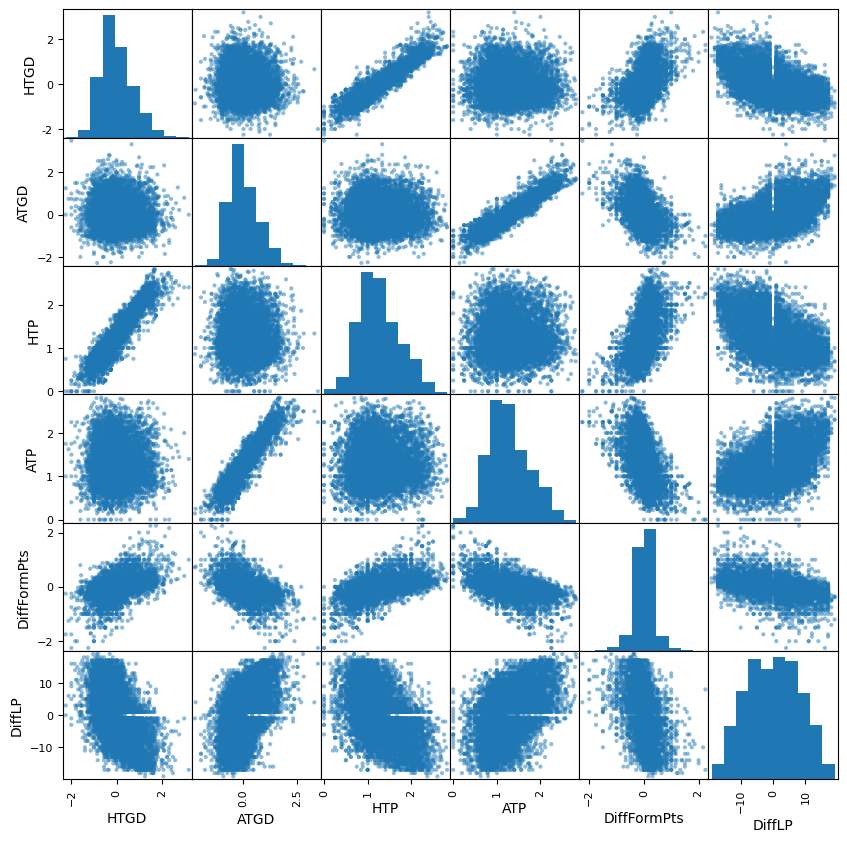

In [ ]:
# Visualising distribution of data
from pandas.plotting import scatter_matrix


scatter_matrix(data[['HTGD','ATGD','HTP','ATP','DiffFormPts','DiffLP']], figsize=(10,10))

In [ ]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('/content/concatenated_file.csv')

# Check the current datatypes of the columns
print("Initial Data Types:")
print(df.dtypes)

Initial Data Types:
Unnamed: 0         int64
Date              object
HomeTeam          object
AwayTeam          object
FTHG               int64
FTAG               int64
FTR               object
HTGS               int64
ATGS               int64
HTGC               int64
ATGC               int64
HTP              float64
ATP              float64
HM1               object
HM2               object
HM3               object
HM4               object
HM5               object
AM1               object
AM2               object
AM3               object
AM4               object
AM5               object
HomeTeamLP       float64
AwayTeamLP       float64
MW               float64
HTFormPtsStr      object
ATFormPtsStr      object
HTFormPts          int64
ATFormPts          int64
HTWinStreak3       int64
HTWinStreak5       int64
HTLossStreak3      int64
HTLossStreak5      int64
ATWinStreak3       int64
ATWinStreak5       int64
ATLossStreak3      int64
ATLossStreak5      int64
HTGD             float64
ATGD 

In [ ]:
print("Initial Data Types:")
print(data.dtypes)

Initial Data Types:
FTR             object
HTP            float64
ATP            float64
HM1             object
HM2             object
HM3             object
AM1             object
AM2             object
AM3             object
HTGD           float64
ATGD           float64
DiffFormPts    float64
DiffLP         float64
dtype: object


In [ ]:
print("Initial Data Types:")
print(df.dtypes)

Initial Data Types:
Unnamed: 0         int64
Date              object
HomeTeam          object
AwayTeam          object
FTHG               int64
FTAG               int64
FTR               object
HTGS               int64
ATGS               int64
HTGC               int64
ATGC               int64
HTP              float64
ATP              float64
HM1               object
HM2               object
HM3               object
HM4               object
HM5               object
AM1               object
AM2               object
AM3               object
AM4               object
AM5               object
HomeTeamLP       float64
AwayTeamLP       float64
MW               float64
HTFormPtsStr      object
ATFormPtsStr      object
HTFormPts          int64
ATFormPts          int64
HTWinStreak3       int64
HTWinStreak5       int64
HTLossStreak3      int64
HTLossStreak5      int64
ATWinStreak3       int64
ATWinStreak5       int64
ATLossStreak3      int64
ATLossStreak5      int64
HTGD             float64
ATGD 

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# # Load the CSV file into a pandas DataFrame
# df = pd.read_csv('your_file.csv')

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Combine the unique team names from both columns
teams = pd.concat([df['AwayTeam'], df['HomeTeam']]).unique()

# Fit the LabelEncoder on the combined list of team names
label_encoder.fit(teams)

# Transform both columns using the same LabelEncoder
df['AwayTeam_encoded'] = label_encoder.transform(df['AwayTeam'])
df['HomeTeam_encoded'] = label_encoder.transform(df['HomeTeam'])

# Display the DataFrame with encoded columns
print(df.head())

# If you want to save the mapping for reference:
team_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nTeam Encoding Mapping:")
print(team_mapping)

# Optionally save the updated DataFrame
df.to_csv('encoded_file.csv', index=False)


   Unnamed: 0        Date  HomeTeam       AwayTeam  FTHG  FTAG FTR  HTGS  \
0           0  2000-08-19  Charlton       Man City     4     0   H     0   
1           1  2000-08-19   Chelsea       West Ham     4     2   H     0   
2           2  2000-08-19  Coventry  Middlesbrough     1     3  NH     0   
3           3  2000-08-19     Derby    Southampton     2     2  NH     0   
4           4  2000-08-19     Leeds        Everton     2     0   H     0   

   ATGS  HTGC  ...  ATWinStreak5  ATLossStreak3  ATLossStreak5 HTGD ATGD  \
0     0     0  ...             0              0              0  0.0  0.0   
1     0     0  ...             0              0              0  0.0  0.0   
2     0     0  ...             0              0              0  0.0  0.0   
3     0     0  ...             0              0              0  0.0  0.0   
4     0     0  ...             0              0              0  0.0  0.0   

  DiffPts DiffFormPts DiffLP AwayTeam_encoded HomeTeam_encoded  
0     0.0         0.0

In [ ]:
unique_values = df['ATFormPtsStr'].unique()

# Display the unique values
print("Unique values in column :")
print(unique_values)

Unique values in column :
['MMMMM' 'WMMMM' 'DMMMM' 'LMMMM' 'WDMMM' 'LDMMM' 'LWMMM' 'WLMMM' 'WWMMM'
 'DWMMM' 'DWLMM' 'DLLMM' 'DLDMM' 'WWLMM' 'LDWMM' 'WDLMM' 'LDDMM' 'DLWWM'
 'WLDDM' 'DDLDM' 'WLWLM' 'DLLWM' 'LDWLM' 'DDLWM' 'DDLLM' 'LWWLM' 'DLDWL'
 'WWLDW' 'WWDDW' 'LLWDL' 'DWWWL' 'DDDLD' 'WWDWD' 'LDLDW' 'WWDLW' 'LDDLD'
 'DLDDL' 'DLDLW' 'WDDWW' 'WLDLL' 'LDDDL' 'DWWLD' 'WDDLL' 'DLWLW' 'LWLDW'
 'LLDLW' 'DWLLW' 'DLWWL' 'LLDWW' 'DDLDL' 'LLDLD' 'DWWWD' 'DDWWD' 'WDWWL'
 'LDLWW' 'LWWLD' 'DWDLD' 'DWWDD' 'LDWWW' 'DLLDL' 'WDLDD' 'LDDWW' 'WLLDW'
 'WDWLL' 'LWDDL' 'WDLLD' 'LWWDL' 'WDDWL' 'WLDDL' 'WLDWW' 'WLLDL' 'LLWDD'
 'LLLDL' 'LWDLL' 'LWWLL' 'DLWWD' 'WDLDL' 'LLDLL' 'WWWLD' 'WLLDD' 'WWWWD'
 'WWLWD' 'WDWDD' 'WLDDW' 'LLLLD' 'WLWLL' 'WLWLD' 'WLLWW' 'LLLLW' 'LLWWL'
 'DWDLW' 'LLLWD' 'LWWLW' 'DWWWW' 'WDWLD' 'WWWWW' 'DWWLL' 'DLWDW' 'LWWWD'
 'WLWWW' 'WLWWD' 'DLWWW' 'WWLWW' 'WWDWL' 'LWLWW' 'WLDWL' 'DLLLL' 'LWLWL'
 'WWLWL' 'LLLLL' 'WWWLL' 'WLWDD' 'LWWWL' 'LLWLD' 'LDLLL' 'DDDLW' 'WLWDW'
 'WLLWD' 'DLLWL' 'WWLLD' 

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the CSV file into a pandas DataFrame
# df = pd.read_csv('your_file.csv')

# Specify the columns you want to label encode
columns_to_encode = ['FTR', 'HM1','HM2','HM3','HM4','HM5','AM1','AM2','AM3','AM4','AM5']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode each specified column
for column in columns_to_encode:
    df[column] = label_encoder.fit_transform(df[column])

# Display the updated DataFrame
print("Label Encoded DataFrame:")
print(df.head())

# If you want to see the mapping for any column:
for column in columns_to_encode:
    print(f"\nMapping for '{column}':")
    mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print(mapping)

# Optionally, save the updated DataFrame to a new CSV file
df.to_csv('encoded_file_le.csv', index=False)


Label Encoded DataFrame:
   Unnamed: 0        Date  HomeTeam       AwayTeam  FTHG  FTAG  FTR  HTGS  \
0           0  2000-08-19  Charlton       Man City     4     0    0     0   
1           1  2000-08-19   Chelsea       West Ham     4     2    0     0   
2           2  2000-08-19  Coventry  Middlesbrough     1     3    1     0   
3           3  2000-08-19     Derby    Southampton     2     2    1     0   
4           4  2000-08-19     Leeds        Everton     2     0    0     0   

   ATGS  HTGC  ...  ATWinStreak5  ATLossStreak3  ATLossStreak5  HTGD  ATGD  \
0     0     0  ...             0              0              0   0.0   0.0   
1     0     0  ...             0              0              0   0.0   0.0   
2     0     0  ...             0              0              0   0.0   0.0   
3     0     0  ...             0              0              0   0.0   0.0   
4     0     0  ...             0              0              0   0.0   0.0   

   DiffPts  DiffFormPts  DiffLP  AwayTeam_e

In [ ]:
print("Initial Data Types:")
print(df.dtypes)

Initial Data Types:
Unnamed: 0            int64
Date                 object
HomeTeam             object
AwayTeam             object
FTHG                  int64
FTAG                  int64
FTR                   int64
HTGS                  int64
ATGS                  int64
HTGC                  int64
ATGC                  int64
HTP                 float64
ATP                 float64
HM1                   int64
HM2                   int64
HM3                   int64
HM4                   int64
HM5                   int64
AM1                   int64
AM2                   int64
AM3                   int64
AM4                   int64
AM5                   int64
HomeTeamLP          float64
AwayTeamLP          float64
MW                  float64
HTFormPtsStr         object
ATFormPtsStr         object
HTFormPts             int64
ATFormPts             int64
HTWinStreak3          int64
HTWinStreak5          int64
HTLossStreak3         int64
HTLossStreak5         int64
ATWinStreak3          int64


In [ ]:
import pandas as pd


# List the columns you want to remove
columns_to_remove = ['Unnamed: 0','Date', 'HomeTeam','AwayTeam']

# Remove the specified columns
df = df.drop(columns=columns_to_remove)

# Display the updated DataFrame
print(df.head())

# Optionally, save the updated DataFrame back to a new CSV file
df.to_csv('updated_file.csv', index=False)

   FTHG  FTAG  FTR  HTGS  ATGS  HTGC  ATGC  HTP  ATP  HM1  ...  ATWinStreak5  \
0     4     0    0     0     0     0     0  0.0  0.0    2  ...             0   
1     4     2    0     0     0     0     0  0.0  0.0    2  ...             0   
2     1     3    1     0     0     0     0  0.0  0.0    2  ...             0   
3     2     2    1     0     0     0     0  0.0  0.0    2  ...             0   
4     2     0    0     0     0     0     0  0.0  0.0    2  ...             0   

   ATLossStreak3  ATLossStreak5  HTGD  ATGD  DiffPts  DiffFormPts  DiffLP  \
0              0              0   0.0   0.0      0.0          0.0     0.0   
1              0              0   0.0   0.0      0.0          0.0    -4.0   
2              0              0   0.0   0.0      0.0          0.0     2.0   
3              0              0   0.0   0.0      0.0          0.0     1.0   
4              0              0   0.0   0.0      0.0          0.0   -10.0   

   AwayTeam_encoded  HomeTeam_encoded  
0               

In [ ]:
print("Initial Data Types:")
print(df.dtypes)

Initial Data Types:
FTHG                  int64
FTAG                  int64
FTR                   int64
HTGS                  int64
ATGS                  int64
HTGC                  int64
ATGC                  int64
HTP                 float64
ATP                 float64
HM1                   int64
HM2                   int64
HM3                   int64
HM4                   int64
HM5                   int64
AM1                   int64
AM2                   int64
AM3                   int64
AM4                   int64
AM5                   int64
HomeTeamLP          float64
AwayTeamLP          float64
MW                  float64
HTFormPtsStr         object
ATFormPtsStr         object
HTFormPts             int64
ATFormPts             int64
HTWinStreak3          int64
HTWinStreak5          int64
HTLossStreak3         int64
HTLossStreak5         int64
ATWinStreak3          int64
ATWinStreak5          int64
ATLossStreak3         int64
ATLossStreak5         int64
HTGD                float64


In [ ]:
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, LayerNormalization,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/updated_file.csv")

# Target column
target = "FTR"
input_columns = [
     "HTGD", "ATGD", "DiffPts", "DiffFormPts",
    "HM1", "HM2", "HM3", "HM4", "HM5",
    "AM1", "AM2", "AM3", "AM4", "AM5"
]
df["DiffPts_MA3"] = df["DiffPts"].rolling(window=3, min_periods=1).mean()
df["DiffPts_MA5"] = df["DiffPts"].rolling(window=5, min_periods=1).mean()
df["DiffFormPts_MA3"] = df["DiffFormPts"].rolling(window=3, min_periods=1).mean()
df["DiffFormPts_MA5"] = df["DiffFormPts"].rolling(window=5, min_periods=1).mean()
df["GoalDiffRatio"] = df["HTGD"] / (df["ATGD"] + 1e-5)
df["HomeWinStreak3"] = df[["HM1", "HM2", "HM3"]].sum(axis=1)
df["AwayWinStreak3"] = df[["AM1", "AM2", "AM3"]].sum(axis=1)

input_columns += [
    "DiffPts_MA3", "DiffPts_MA5", "DiffFormPts_MA3", "DiffFormPts_MA5",
    "GoalDiffRatio", "HomeWinStreak3", "AwayWinStreak3"
]

label_encoder = LabelEncoder()
df[target] = label_encoder.fit_transform(df[target])

scaler = MinMaxScaler()
df[input_columns] = scaler.fit_transform(df[input_columns])


df.to_csv('test.csv', index=False)

Selected Features: ['DiffPts', 'HTGD', 'ATGD', 'DiffPts_MA5', 'DiffPts_MA3', 'DiffFormPts_MA5', 'DiffFormPts_MA3', 'DiffFormPts', 'GoalDiffRatio', 'HomeTeamLP', 'HomeTeamLP', 'AwayTeamLP', 'AwayTeamLP', 'HomeWinStreak3', 'AwayWinStreak3']
New class distribution after SMOTE: [4071 4071]
Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.5634 - loss: 1.4529 - val_accuracy: 0.4979 - val_loss: 1.1620 - learning_rate: 0.0010
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5896 - loss: 1.1634 - val_accuracy: 0.4979 - val_loss: 1.0625 - learning_rate: 0.0010
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5804 - loss: 1.0551 - val_accuracy: 0.4979 - val_loss: 0.9959 - learning_rate: 0.0010
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6279 - loss: 0.9599 - val_accuracy: 0.4979 - val_loss: 0.9486 - learning_rate: 0.0010
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6223 - loss: 0.9116 - val_accuracy: 0.

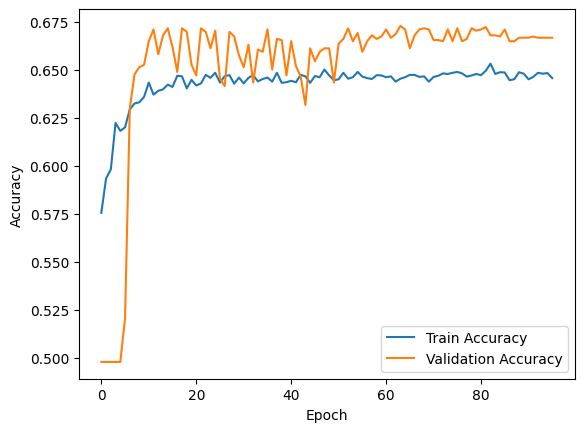

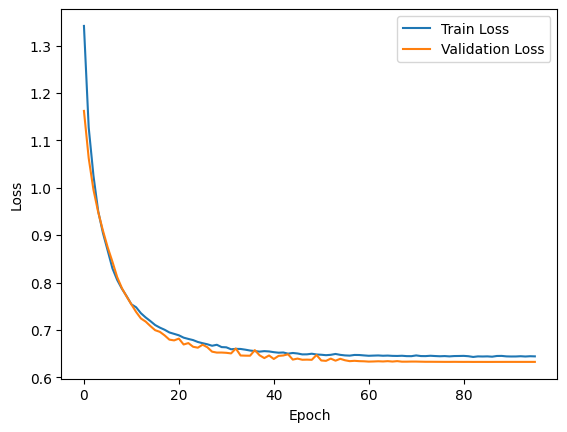

In [ ]:
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, LayerNormalization,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from tensorflow.keras.losses import CategoricalCrossentropy

# Load the dataset
df = pd.read_csv("/content/test.csv")

# Target column
target = "FTR"

input_columns += [
    "HomeTeamLP", "AwayTeamLP"
]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df[input_columns], df[target])
feature_importances = pd.Series(rf.feature_importances_, index=input_columns).sort_values(ascending=False)
selected_features = feature_importances[feature_importances > 0.02].index.tolist()
print("Selected Features:", selected_features)

X = df[selected_features].values
y = df[target].values
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

y_resampled = tf.keras.utils.to_categorical(y_resampled)

sequence_length = 1 # change sequence length to 1
X_resampled = X_resampled.reshape(X_resampled.shape[0], sequence_length, X_resampled.shape[1] // sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print(f"New class distribution after SMOTE: {np.bincount(np.argmax(y_resampled, axis=1))}")


model = Sequential([
    LayerNormalization(),

    Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.15, kernel_regularizer=l2(0.001))),
    BatchNormalization(),

    Bidirectional(LSTM(64, recurrent_dropout=0.15, kernel_regularizer=l2(0.001))),
    BatchNormalization(),

    Dropout(0.3),  # Reduced from 0.5

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(y_train.shape[1], activation='softmax')
])


loss = CategoricalCrossentropy(label_smoothing=0.1)
optimizer = Adam(learning_rate=0.001)#momentum rmsprop
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping, lr_reduction]
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save('model.h5')

In [ ]:
model.save('my_model.keras')


In [ ]:
import numpy as np

from tensorflow.keras.models import load_model
# sample_input = np.array([[5,36,   29,30,  9,15, 0.625,5,0.875,30,30,25,25,2.3,4.3]])
sample_input = np.array([[1, 18, 16, 3, 2, 2, 1, 1, 1.125, 2, 2, 1, 1, 3, 1]])
# Liverpool and Manchester City on December 1, 2024


sample_input = sample_input.reshape((1, 1, sample_input.shape[1]))
model=load_model('/content/model.h5')

predicted_output = model.predict(sample_input)

predicted_class = np.argmax(predicted_output)


print(f"Predicted Class: {predicted_class}")
print(f"Prediction Probabilities: {predicted_output}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: 0
Prediction Probabilities: [[0.7627968  0.23720314]]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_prediction(sample_input, predicted_output):
    # Changed labels to reflect 2 outcomes: Home Win and Away Win
    labels = ['Home Win', 'Away Win']
    probabilities = predicted_output.flatten()
    predicted_class = np.argmax(probabilities)

    # 1. Summary Info
    print("==== 🧠 Match Prediction Summary ====")
    print(f"🏆 Predicted Outcome: {labels[predicted_class]}")
    print(f"🔢 Confidence: {probabilities[predicted_class]:.2%}")
    print(f"📊 All Probabilities: " + ", ".join([f"{l}: {p:.2%}" for l, p in zip(labels, probabilities)]))

    # 2. Bar Chart of Probabilities
    plt.figure(figsize=(6, 4))
    plt.bar(labels, probabilities, color=['skyblue', 'salmon'])  # Updated colors for 2 bars
    plt.title("Predicted Match Outcome Probabilities")
    plt.ylabel("Probability")
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # 3. Recent Form Analysis
    home_form = sample_input[0, 0, -10:-5]
    away_form = sample_input[0, 0, -5:]
    home_avg = np.mean(home_form)
    away_avg = np.mean(away_form)

    print("\n📈 Recent Form Breakdown:")
    print("🏠 Home Team Last 5 Matches:", home_form)
    print("✈️  Away Team Last 5 Matches:", away_form)
    print(f"📉 Avg Home Form: {home_avg:.2f}")
    print(f"📉 Avg Away Form: {away_avg:.2f}")

    # 4. Plot form trend
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, 6), home_form, marker='o', label='Home Team', color='blue')
    plt.plot(range(1, 6), away_form, marker='o', label='Away Team', color='red')
    plt.title("Last 5 Match Results (Form)")
    plt.xlabel("Match Index (1 = Oldest)")
    plt.ylabel("Points")
    plt.legend()
    plt.grid(True)
    plt.show()


==== 🧠 Match Prediction Summary ====
🏆 Predicted Outcome: Home Win
🔢 Confidence: 76.28%
📊 All Probabilities: Home Win: 76.28%, Away Win: 23.72%


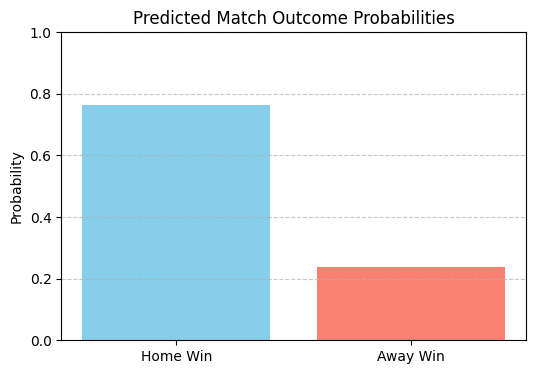


📈 Recent Form Breakdown:
🏠 Home Team Last 5 Matches: [2.    1.    1.    1.125 2.   ]
✈️  Away Team Last 5 Matches: [2. 1. 1. 3. 1.]
📉 Avg Home Form: 1.43
📉 Avg Away Form: 1.60


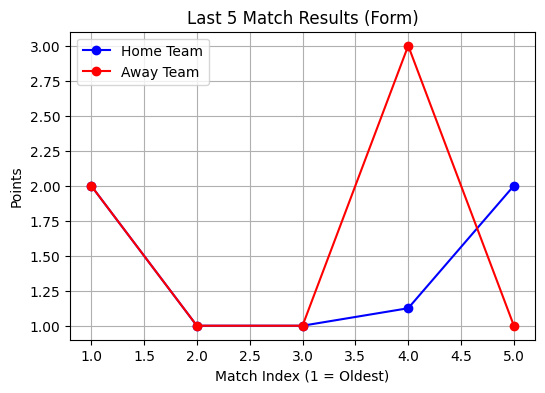

In [ ]:
analyze_prediction(sample_input, predicted_output)

In [ ]:
target = "FTR"

input_columns = ["HTGD", "ATGD", "DiffPts", "DiffFormPts",
    "HM1", "HM2", "HM3", "HM4", "HM5",
    "AM1", "AM2", "AM3", "AM4", "AM5"


]
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df[input_columns], df[target])
feature_importances = pd.Series(rf.feature_importances_, index=input_columns).sort_values(ascending=False)
selected_features = feature_importances[feature_importances > 0.02].index.tolist()
print("Selected Features:", selected_features)

Selected Features: ['DiffPts', 'HTGD', 'ATGD', 'DiffFormPts', 'AM5', 'HM1', 'AM1', 'AM2', 'HM3', 'AM4', 'HM5', 'AM3', 'HM2', 'HM4']


In [ ]:
X = df[selected_features].values
y = df[target].values
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

y_resampled = tf.keras.utils.to_categorical(y_resampled)

sequence_length = 1 # change sequence length to 1
X_resampled = X_resampled.reshape(X_resampled.shape[0], sequence_length, X_resampled.shape[1] // sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
if len(X_train.shape) == 3:
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

Logistic Regression Accuracy: 0.6384


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred):.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.6354


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Random Forest Accuracy: 0.6519


In [ ]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear')  # You can try 'rbf' as well
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred):.4f}")


SVM Accuracy: 0.6409


In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)
print(f"Naïve Bayes Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Naïve Bayes Accuracy: 0.6433


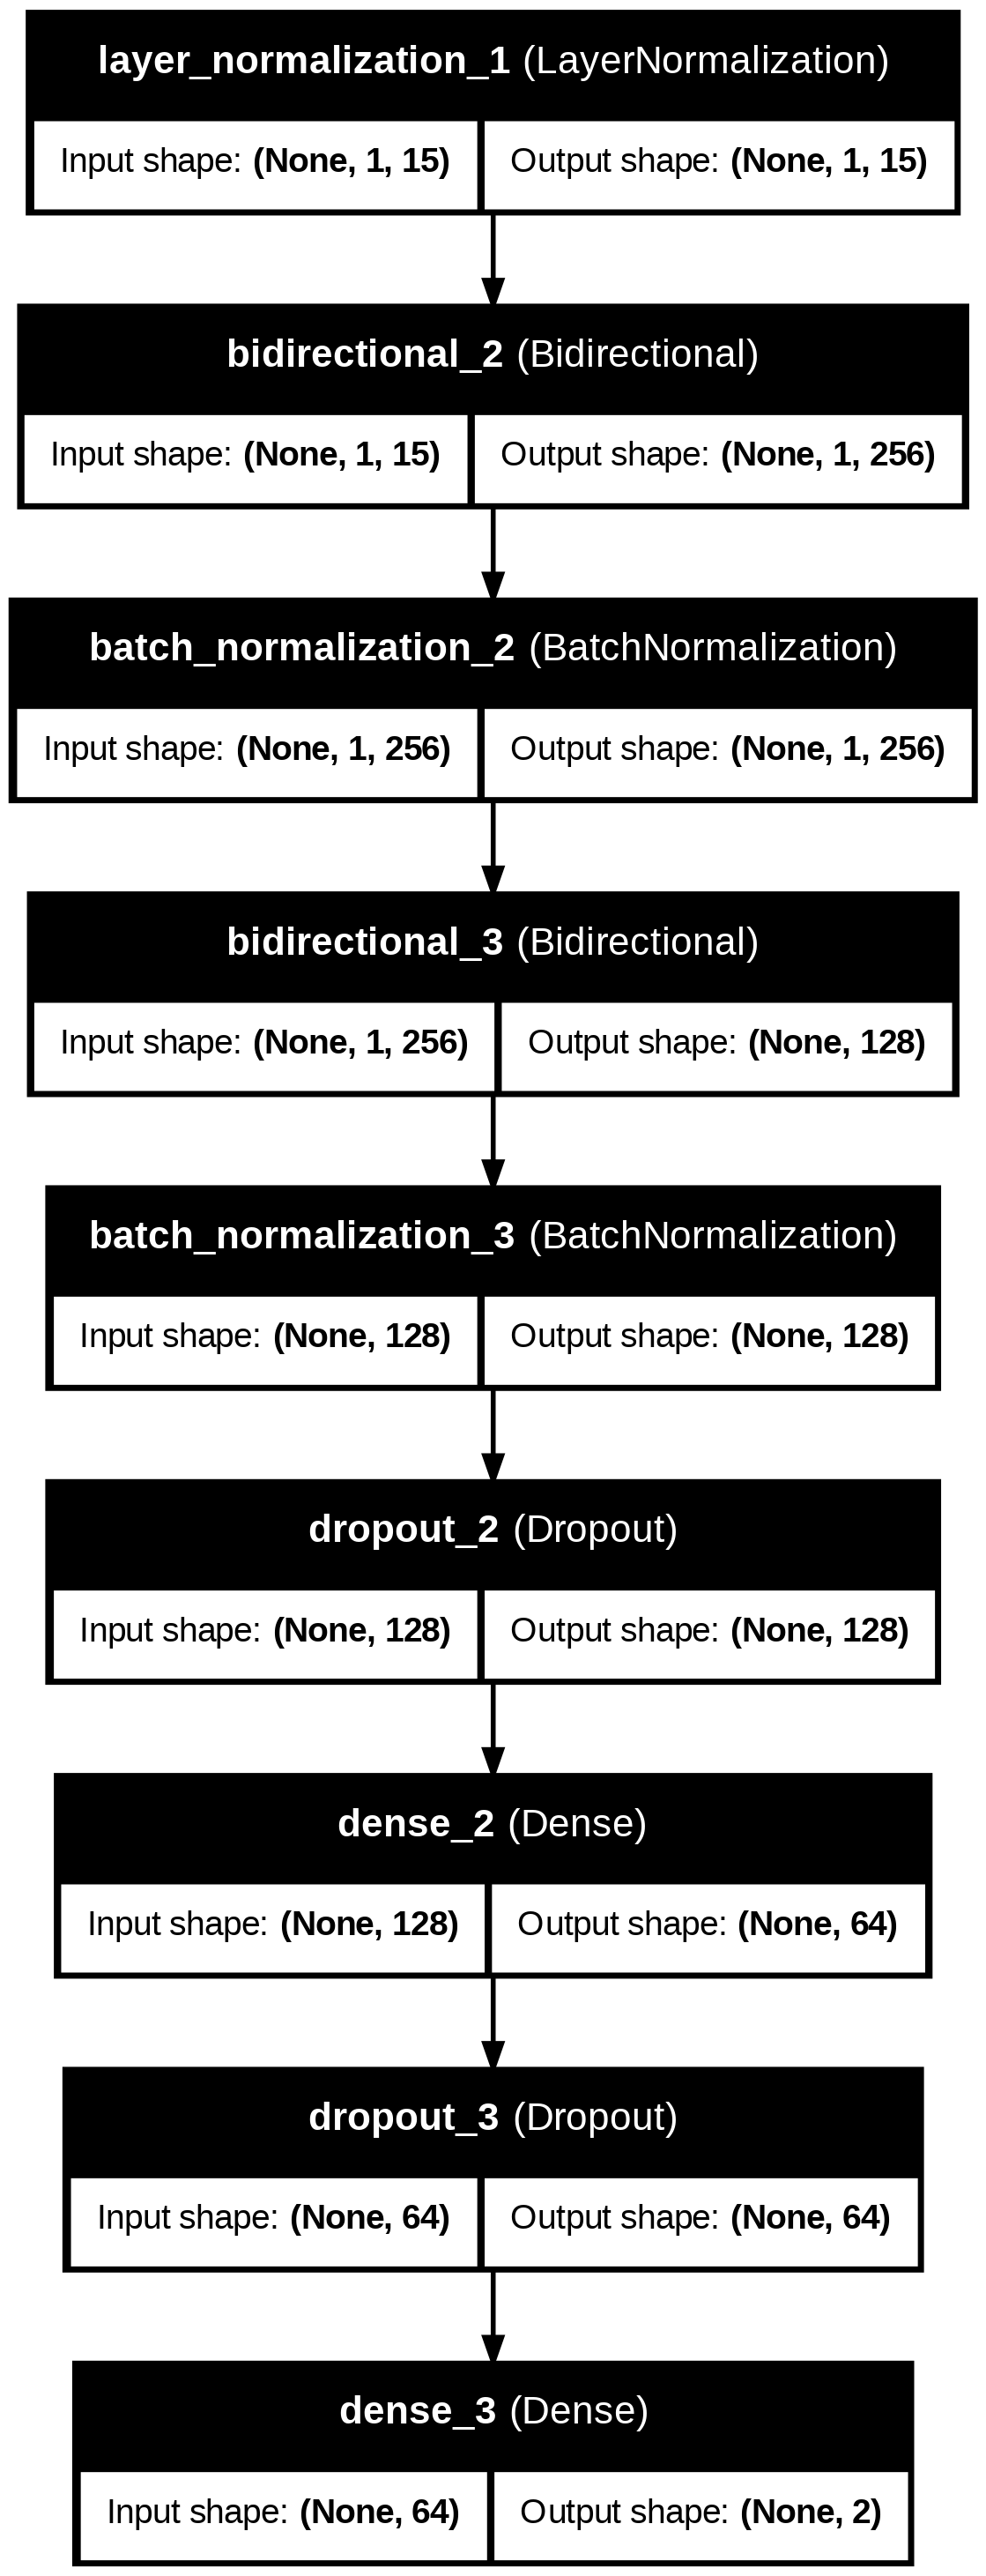

In [ ]:
from tensorflow.keras.utils import plot_model

# Save model plot to file
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display image in Colab
from IPython.display import Image
Image(filename='model_architecture.png')
